In [1]:
from datetime import datetime, time, timedelta
import gzip

import matplotlib.pyplot as plt
import numpy as np
from osgeo import osr
import pandas as pd
import seaborn as sns

# Set styles for plots
sns.set()
sns.set_context("talk")

In [2]:
SEED = 16
np.random.seed(SEED)

# Postprocessing parameters
From the simulation, we collected data on customer wait times and fleet travel distances. This notebook contains the post-processing pipeline to perform the following:

1. Compare the following policies:
* Model-free adaptive repositioning (MF)
* Demand-supply (DS)
* Global bipartite matching (GBM)
2. Compare across different fleet sizes
3. Compare across income ranges
4. Compare across age ranges

In [3]:
# Parameters used in experiment
policies = ['mf', 'ds', 'gbm']
fleet_sizes = [25, 50, 100, 150, 200]

# Simulation trip results
LEGS_FILE = 'output_legs.csv.gz'

# Wait/request times
TIME_FILE = 'data/RequestTravelTimes/RequestTravelTimes.csv'
TIME_COLS = ('request index', 'submission time', 'assignment time',
            'pickup time', 'dropoff time')

# Travel distances
DISTANCE_FILE = 'data/DistancesOverDay/DistancesOverDay.csv'
DIST_COLS = ('time_step', 'total', 'with_customer',
             'pickup', 'rebalancing', 'distance_ratio')

# Metrics for plotting
METRICS = ['wait time', 'distance']

# Person attributes
ATTRIBUTES = ['income range', 'age range']

# Groups
income_groups = ['0-15K', '15-40K', '40-60K', '60-100K', '100-125K', '125K+', 'UNK']
age_groups = ['11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+', 'UNK']

# For plotting
ATTRIBUTE_TO_GROUPS = {'income range': income_groups, 'age range': age_groups}

def get_data_file(policy, fleet_size, fname):
    return "{}_fs_{}/{}".format(policy, fleet_size, fname)

In [4]:
class EPSGConverter:
    def __init__(self, src=3161, tgt=4326):
        self.inp = osr.SpatialReference()
        self.inp.ImportFromEPSG(src)
        self.out = osr.SpatialReference()
        self.out.ImportFromEPSG(tgt)
        self.tf = osr.CoordinateTransformation(self.inp, self.out)
    
    def transform(self, x, y):
        x, y = float(x), float(y)
        return self.tf.TransformPoint(x, y)[:2]

epsg_converter = EPSGConverter()

# Read actual trip data from the simulation
When the simulation is run, it creates an `output_legs.csv.gz` file which contains the simulation's measurements of when and where each trip took place. The trips in this file correspond exactly to the input trips file, but with newly computed wait times, travel times, and travel distances. 

In [5]:
def get_legs(infile):
    try:
        with gzip.open(infile, 'r') as f:
            df = pd.read_csv(f, delimiter=';')
    except:
        print("File not found")
        return pd.DataFrame()
        
    df['temp'] = df.apply(
        lambda x: epsg_converter.transform(x['start_x'], x['start_y']),
        axis=1)
    df[['start_lat', 'start_long']] = pd.DataFrame(df['temp'].tolist(), index=df.index)
    df['temp'] = df.apply(
        lambda x: epsg_converter.transform(x['end_x'], x['end_y']),
        axis=1)
    df[['end_lat', 'end_long']] = pd.DataFrame(df['temp'].tolist(), index=df.index)
    
    # Convert travel and wait times to seconds
    df['trav_time'] = pd.to_timedelta(df['trav_time']).dt.total_seconds() / 60
    df['wait_time'] = pd.to_timedelta(df['wait_time']).dt.total_seconds() / 60
    df['trav_time'] -= df['wait_time']
    df.rename({'trav_time': 'travel_time'}, axis=1, inplace=True)
    
    # Convert distance to km
    df['distance'] = df['distance'] / 1000.0
    
    # Set index to person ID
    df['person'] = df['person'].str.lstrip('no_dat_id_').astype(int)
    df = df.set_index('person')
    df = df.drop(['temp', 'trip_id', 'start_x', 'start_y',
                  'end_x', 'end_y', 'access_stop_id', 'egress_stop_id',
                  'transit_line', 'transit_route'], axis=1)
    return df.sort_index()

# Plot Y vs. fleet size

Examine how wait times and fleet travel distance are affected by the fleet size and operational policy.

## Using the legs file
The `output_legs` file contains trip-by-trip data on the wait times and fleet travel distances. Interestingly, we get different results from this file than we do with the less granular CSV files containing the same information under the `data` directory.

In [6]:
def agg_metrics(df, cols):
    # mean and 90th percentile
    means = ['mean_wait_time', 'mean_travel_time', 'mean_distance']
    ninety = ['90th_wait_time', '90th_travel_time', '90th_distance']
    try:
        result = {
            **df[cols].mean().rename(
            {old: new for old, new in zip(cols, means)}).to_dict(),
            **df[cols].quantile(0.9).rename(
            {old: new for old, new in zip(cols, ninety)}).to_dict()
        }
        return result
    
    except:
        print("Error: dataframe not found")
        return {d: np.nan for d in [*means, *ninety]}

def get_leg_metrics(policies, fleet_sizes):
    columns = ['mean_wait_time', 'mean_travel_time', 'mean_distance',
               '90th_wait_time', '90th_travel_time', '90th_distance',
               'policy', 'fleet_size']
    result = []
    
    # Iterate through each policy's reports for all fleet sizes
    for p in policies:
        for fs in fleet_sizes:
            f = get_data_file(p, fs, LEGS_FILE)
            trips = get_legs(f)
            curr = agg_metrics(trips, cols=['wait_time', 'travel_time', 'distance'])
            curr['policy'] = p
            curr['fleet_size'] = fs
            result.append(curr)
            
    return pd.DataFrame.from_records(result)
   
get_leg_metrics(policies, fleet_sizes)

,mean_wait_time,mean_travel_time,mean_distance,90th_wait_time,90th_travel_time,90th_distance,policy,fleet_size
0,131.662987,11.240158,12.227677,386.401667,18.300000,20.7450,mf,25
1,13.495510,11.142698,12.117928,28.500000,18.163333,20.5098,mf,50
2,4.846692,11.142810,12.117928,10.123333,18.163333,20.5098,mf,100
3,3.568842,11.143223,12.117928,7.250000,18.163333,20.5098,mf,150
4,2.981200,11.143160,12.117928,6.026667,18.163333,20.5098,mf,200
5,135.289187,11.186681,12.167353,368.400000,18.266667,20.6654,ds,25
6,15.068401,11.142698,12.117928,28.926667,18.163333,20.5098,ds,50
7,6.747783,11.143202,12.117928,12.800000,18.163333,20.5098,ds,100
8,5.663631,11.142887,12.117928,10.930000,18.163333,20.5098,ds,150
9,4.905008,11.143307,12.117928,9.846667,18.163333,20.5098,ds,200


## Using the data files
The data files are also generated during simulation on a per timestamp basis, but the mean wait time calculated is slightly greater than the value calculated from the `output_legs` file.

In [7]:
def get_vals_generic(fname, cols, metric, divisor=1.0):
    try:
        df = pd.read_csv(fname, header=None, names=cols) / divisor
        return df.agg(metric).to_dict()
    except:
        print("File {} not found".format(fname))

def get_summary_metrics(policies, fleet_sizes, fname,
                        cols, metric, divisor):
    result = []
    for p in policies:
        for fs in fleet_sizes:
            f = get_data_file(p, fs, fname)
            curr = get_vals_generic(f, cols, metric, divisor)
            if curr:
                curr['policy'] = p
                curr['fleet size'] = fs
                result.append(curr)

    return pd.DataFrame.from_records(result)

## Fleet distance
When traveling, AVs can be in one of three states: with customer, pickup, or rebalancing (moving to a new location without a customer). **Model-free adaptive repositioning (MF)** is the only fleet policy with rebalancing. As a result, we expect the total distance travelled to be greater than the others (in return for lower pickup distance and wait times).

In [8]:
total_distances = get_summary_metrics(policies, fleet_sizes,
                                     DISTANCE_FILE, DIST_COLS, 'sum', 1000.0)
total_distances

,time_step,total,with_customer,pickup,rebalancing,distance_ratio,policy,fleet size
0,194454.0,37220.631180,27485.673880,8972.080492,762.876808,0.0,mf,25
1,194454.0,51854.484313,28878.225491,14749.008565,8227.250257,0.0,mf,50
2,194454.0,60816.888149,28878.225491,9123.494633,22815.168024,0.0,mf,100
3,194454.0,63701.324351,28878.551082,6605.024588,28217.748681,0.0,mf,150
4,194454.0,64679.665940,28878.670379,5382.730715,30418.264846,0.0,mf,200
5,194454.0,37380.816657,28020.253734,9360.562923,0.000000,0.0,ds,25
6,194454.0,48890.847820,28878.225491,20012.622329,0.000000,0.0,ds,50
7,194454.0,44276.593596,28878.455943,15398.137653,0.000000,0.0,ds,100
8,194454.0,41605.930782,28878.920332,12727.010450,0.000000,0.0,ds,150
9,194454.0,39509.203007,28879.349979,10629.853029,0.000000,0.0,ds,200


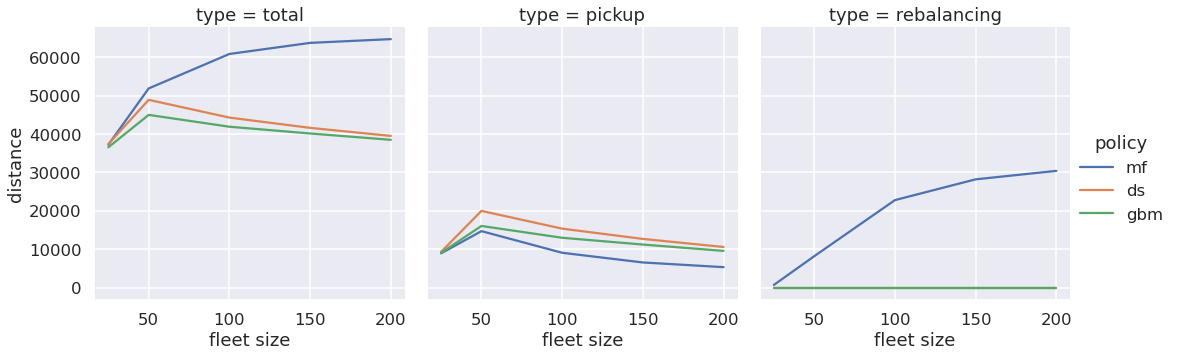

In [9]:
total_dist_clean = pd.melt(total_distances,
        id_vars=['policy', 'fleet size'],
        value_vars=['total', 'pickup', 'rebalancing'], value_name='distance', var_name='type')

sns.relplot(
    x='fleet size',
    y='distance',
    hue='policy',
    col='type',
    kind='line',
    data=total_dist_clean
)

## Wait times
Wait times are calculated by subtracting the submission time (when the trip was requested) from the pickup time (when the customer entered the vehicle in simulation). Wait time expectedly goes down with increased fleet size. The rebalancing MF policy consistently outperforms the other two policies.

In [10]:
mean_reqtimes = get_summary_metrics(policies, fleet_sizes,
                                    TIME_FILE, TIME_COLS, 'mean', 60.0)
mean_reqtimes['wait time'] = mean_reqtimes['pickup time'] - mean_reqtimes['submission time']
mean_reqtimes

,request index,submission time,assignment time,pickup time,dropoff time,policy,fleet size,wait time
0,19.85,971.633235,1117.558540,1121.991817,1132.621695,mf,25,150.358582
1,19.85,971.633235,980.608687,985.368863,996.550357,mf,50,13.735627
2,19.85,971.633235,973.099454,976.717793,987.896349,mf,100,5.084557
3,19.85,971.633235,972.572598,975.440621,986.619178,mf,150,3.807386
4,19.85,971.633235,972.379773,974.857323,986.030214,mf,200,3.224087
5,19.85,971.633235,1113.781578,1117.709820,1128.547209,ds,25,146.076584
6,19.85,971.633235,979.050357,986.942509,998.116869,ds,50,15.309274
7,19.85,971.633235,972.301511,978.624003,989.798154,ds,100,6.990768
8,19.85,971.633235,972.133235,977.538607,988.715275,ds,150,5.905371
9,19.85,971.633235,972.133235,976.778640,987.957616,ds,200,5.145405


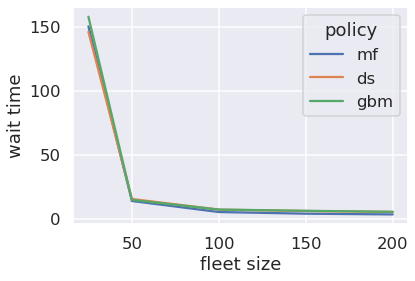

In [11]:
sns.lineplot(
    x='fleet size',
    y='wait time',
    hue='policy',
    data=mean_reqtimes
)

# Wait times and travel distance across demographic groups
Load the original trips file and join with the simulation trips file. There will be some dropped trips and differences in the exact pickup/dropoff locations since AMoDeus resamples points during scenario creation. We can then compare the effects of the AV fleet policies on different age and income groups.

In [12]:
# Original df
original_trips = pd.read_csv('../../amodtaxi/src/main/resources/torontoScenario/trips_final.csv')
original_trips.head()

,trip_id,trip_start_timeslot,trip_start_timestamp,trip_end_timestamp,duration,distance,origin_ward,dest_ward,origin_lat,origin_long,dest_lat,dest_long,age_range,income_range
0,0,400,2020-09-20T04:00:00.000,2020-09-20T04:06:36.499,6.304165,5.253471,20,27,43.640757,-79.381323,43.687599,-79.372805,21-30,100-125K
1,1,400,2020-09-20T04:01:00.000,2020-09-20T04:03:30.700,2.255835,1.879863,20,27,43.664528,-79.395936,43.658913,-79.373894,21-30,100-125K
2,2,400,2020-09-20T04:01:00.000,2020-09-20T04:11:55.570,9.963085,8.302571,19,11,43.662746,-79.414158,43.698959,-79.504449,21-30,40-60K
3,3,400,2020-09-20T04:01:00.000,2020-09-20T04:11:16.986,10.141556,8.451297,19,11,43.643408,-79.414613,43.683323,-79.504022,21-30,40-60K
4,4,400,2020-09-20T04:03:00.000,2020-09-20T04:15:46.992,12.391606,10.326339,20,6,43.640491,-79.392403,43.597107,-79.505824,41-50,15-40K


In [13]:
# Simulated df (model-free)
policy = 'mf'
fleet_size = 200
sim_file = get_data_file(policy, fleet_size, LEGS_FILE)
sim_trips = get_legs(sim_file)
sim_trips.head()

,dep_time,travel_time,wait_time,distance,mode,start_link,end_link,start_lat,start_long,end_lat,end_long
person,,,,,,,,,,,
2,04:01:00,10.183333,1.683333,10.842,av,407357,528971,43.663090,-79.414366,43.698689,-79.504724
3,04:01:00,11.666667,0.733333,10.897,av,575877,531140,43.643347,-79.414425,43.684886,-79.504577
4,04:03:00,13.316667,1.066667,15.036,av,393281,89936,43.640700,-79.392270,43.596685,-79.506126
9,04:04:00,15.583333,0.916667,16.309,av,235983,328776,43.666827,-79.418385,43.611585,-79.545096
19,04:35:00,17.233333,2.100000,17.915,av,84731,395433,43.733433,-79.253548,43.671608,-79.388997


Note that the simulation filters out some trips that are outside of the acceptable range of link speeds and trip durations.

In [14]:
def get_combined_trips(original, sim):
    attributes = list(map(lambda x: '_'.join(x.split()), ATTRIBUTES))
    combined = pd.concat((sim, original[attributes]), axis=1, join='inner')
    combined.rename(
    {'travel_time': 'travel time',
     'wait_time': 'wait time',
     'income_range': 'income range',
     'age_range': 'age range'}, axis=1, inplace=True)
    combined.dropna(inplace=True)
    return combined

combined = get_combined_trips(original_trips, sim_trips)
combined.head()

,dep_time,travel time,wait time,distance,mode,start_link,end_link,start_lat,start_long,end_lat,end_long,income range,age range
2,04:01:00,10.183333,1.683333,10.842,av,407357,528971,43.663090,-79.414366,43.698689,-79.504724,40-60K,21-30
3,04:01:00,11.666667,0.733333,10.897,av,575877,531140,43.643347,-79.414425,43.684886,-79.504577,40-60K,21-30
4,04:03:00,13.316667,1.066667,15.036,av,393281,89936,43.640700,-79.392270,43.596685,-79.506126,15-40K,41-50
9,04:04:00,15.583333,0.916667,16.309,av,235983,328776,43.666827,-79.418385,43.611585,-79.545096,15-40K,41-50
19,04:35:00,17.233333,2.100000,17.915,av,84731,395433,43.733433,-79.253548,43.671608,-79.388997,UNK,51-60


In [15]:
def get_combined_metrics(combined):
    metrics = {}
    for v in METRICS:
        metrics[v] = {
            'income': combined[['income range', v]].groupby('income range'),
            'age': combined[['age range', v]].groupby('age range')
        }
    return metrics

metrics = get_combined_metrics(combined)

In [16]:
metrics['wait time']['income'].describe()

wait time                                                    \
                 count      mean       std       min       25%       50%   
income range                                                               
0-15K            132.0  3.962500  2.466086  0.283333  2.216667  3.516667   
100-125K         228.0  3.452193  2.648570  0.283333  1.500000  2.650000   
125K+            628.0  2.171603  1.767306  0.283333  0.966667  1.633333   
15-40K           384.0  3.463889  3.029269  0.283333  1.512500  2.650000   
40-60K           316.0  3.179167  2.288024  0.283333  1.579167  2.591667   
60-100K          420.0  3.134722  2.554042  0.283333  1.366667  2.325000   
UNK              275.0  2.832545  2.362343  0.283333  1.350000  2.183333   

                                   
                   75%        max  
income range                       
0-15K         5.104167  12.216667  
100-125K      4.654167  16.183333  
125K+         2.754167  13.183333  
15-40K        4.133333  18.550000  
40-60K        4.433333  12.416667  
60-100K       3.900000  17.150000  
UNK           3.816667  21.200000

In [17]:
metrics['wait time']['age'].describe()

wait time                                                    \
              count      mean       std       min       25%       50%   
age range                                                               
11-20         124.0  3.364651  2.294195  0.283333  1.704167  2.841667   
21-30         605.0  2.691515  1.939101  0.283333  1.283333  2.200000   
31-40         587.0  3.017433  2.708304  0.283333  1.125000  2.166667   
41-50         429.0  2.929448  2.526673  0.283333  1.266667  2.033333   
51-60         263.0  2.985551  2.541277  0.283333  1.408333  2.200000   
61-70         177.0  2.777589  2.501509  0.283333  1.250000  2.083333   
71+           197.0  3.814213  2.787286  0.283333  1.966667  3.183333   
UNK             1.0  2.416667       NaN  2.416667  2.416667  2.416667   

                                
                75%        max  
age range                       
11-20      4.545833  12.216667  
21-30      3.466667  10.566667  
31-40      4.008333  18.550000  
41-50      3.783333  16.100000  
51-60      3.525000  14.483333  
61-70      3.333333  17.150000  
71+        4.900000  21.200000  
UNK        2.416667   2.416667

In [18]:
def boxplot(x, y, data, order, orient='h', palette="Set2", figname=None):
    plt.clf()
    plot = sns.boxplot(x=x, y=y, data=data, order=order, orient=orient, palette=palette)
    if figname:
        plot.figure.savefig(figname, bbox_inches='tight')

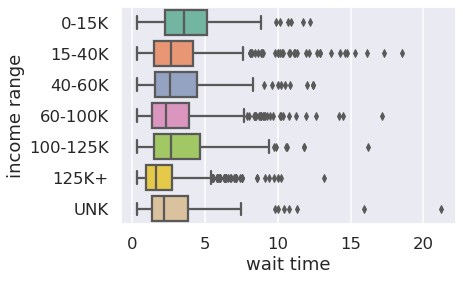

In [19]:
boxplot('wait time', 'income range', combined, income_groups, figname='test')

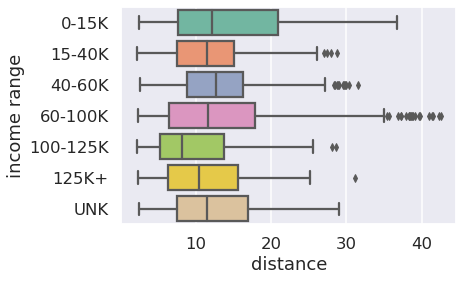

In [20]:
boxplot('distance', 'income range', combined, income_groups)

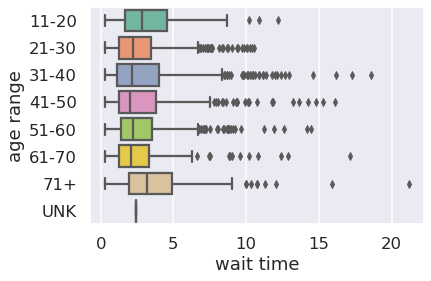

In [21]:
boxplot('wait time', 'age range', combined, age_groups)

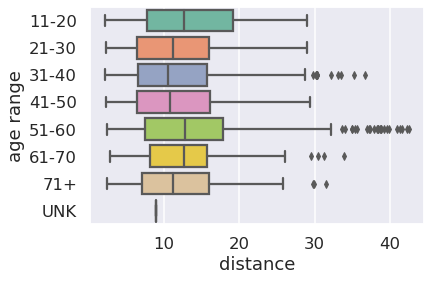

In [22]:
boxplot('distance', 'age range', combined, age_groups)

Now plot for all the policies and fleet sizes.

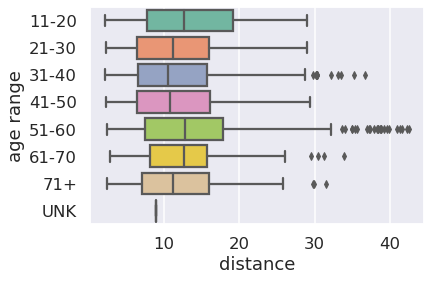

In [23]:
def plot_all(original_trips):
    for policy in policies:
        for fleet_size in fleet_sizes:
            sim_trips = get_legs(get_data_file(policy, fleet_size, LEGS_FILE))
            combined = get_combined_trips(original_trips, sim_trips)
            for metric in METRICS:
                for attribute, group in ATTRIBUTE_TO_GROUPS.items():
                    boxplot(metric, attribute, combined, group, figname='figures/{}_{}_{}_{}.png'.format(attribute.split()[0], metric[0], policy, fleet_size))

plot_all(original_trips)
            